In [4]:
import numpy as np
import numpy
import scipy as sp
from scipy.special import gammaln

In [15]:
"""
(C) Mathieu Blondel - 2010
License: BSD 3 clause

Implementation of the collapsed Gibbs sampler for
Latent Dirichlet Allocation, as described in

Finding scientifc topics (Griffiths and Steyvers)
"""

import numpy as np
import scipy as sp
from scipy.special import gammaln

def sample_index(p):
    """
    Sample from the Multinomial distribution and return the sample index.
    """
    return np.random.multinomial(1,p).argmax()

def word_indices(vec):
    """
    Turn a document vector of size vocab_size to a sequence
    of word indices. The word indices are between 0 and
    vocab_size-1. The sequence length is equal to the document length.
    """
    for idx in vec.nonzero()[0]:
        for i in xrange(int(vec[idx])):
            yield idx

def log_multi_beta(alpha, K=None):
    """
    Logarithm of the multinomial beta function.
    """
    if K is None:
        # alpha is assumed to be a vector
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        # alpha is assumed to be a scalar
        return K * gammaln(alpha) - gammaln(K*alpha)

class LdaSampler(object):

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """
        n_topics: desired number of topics
        alpha: a scalar (FIXME: accept vector of size n_topics)
        beta: a scalar (FIME: accept vector of size vocab_size)
        """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def _initialize(self, matrix):
        n_docs, vocab_size = matrix.shape

        # number of times document m and topic z co-occur
        self.nmz = np.zeros((n_docs, self.n_topics))
        # number of times topic z and word w co-occur
        self.nzw = np.zeros((self.n_topics, vocab_size))
        self.nm = np.zeros(n_docs)
        self.nz = np.zeros(self.n_topics)
        self.topics = {}

        for m in xrange(n_docs):
            # i is a number between 0 and doc_length-1
            # w is a number between 0 and vocab_size-1
            #print m, matrix[m, :] #, word_indices(matrix[m, :])
            for i, w in enumerate(word_indices(matrix[m, :])):
                # choose an arbitrary topic as first topic for word i
                #print 'i,w',i,w
                z = np.random.randint(self.n_topics)
                self.nmz[m,z] += 1
                self.nm[m] += 1
                self.nzw[z,w] += 1
                self.nz[z] += 1
                self.topics[(m,i)] = z

    def _conditional_distribution(self, m, w):
        """
        Conditional distribution (vector of size n_topics).
        """
        vocab_size = self.nzw.shape[1]
        left = (self.nzw[:,w] + self.beta) / \
               (self.nz + self.beta * vocab_size)
        right = (self.nmz[m,:] + self.alpha) / \
                (self.nm[m] + self.alpha * self.n_topics)
        #print 'left',left
        #print 'right',right
        #print 'sizes',left.shape,right.shape
        p_z = left * right
        # normalize to obtain probabilities
        p_z /= np.sum(p_z)
        print 'p_z',p_z
        return p_z

    def loglikelihood(self):
        """
        Compute the likelihood that the model generated the data.
        """
        vocab_size = self.nzw.shape[1]
        n_docs = self.nmz.shape[0]
        lik = 0

        for z in xrange(self.n_topics):
            lik += log_multi_beta(self.nzw[z,:]+self.beta)
            lik -= log_multi_beta(self.beta, vocab_size)

        for m in xrange(n_docs):
            lik += log_multi_beta(self.nmz[m,:]+self.alpha)
            lik -= log_multi_beta(self.alpha, self.n_topics)

        return lik

    def phi(self):
        """
        Compute phi = p(w|z).
        """
        V = self.nzw.shape[1]
        num = self.nzw + self.beta
        num /= np.sum(num, axis=1)[:, np.newaxis]
        return num

    def run(self, matrix, maxiter=2): #2 used to be 30 TODO: change it back
        """
        Run the Gibbs sampler.
        """
        n_docs, vocab_size = matrix.shape
        self._initialize(matrix)

        for it in xrange(maxiter):
            for m in xrange(n_docs):
                print 'it, m, matrix[m, :]',it, m, matrix[m, :]
                for i, w in enumerate(word_indices(matrix[m, :])):
                    print 'iteration, doc, index, word',it, m, i, w
                    z = self.topics[(m,i)]
                    self.nmz[m,z] -= 1
                    self.nm[m] -= 1
                    self.nzw[z,w] -= 1
                    self.nz[z] -= 1

                    print 'prev z',z
                    p_z = self._conditional_distribution(m, w)
                    z = sample_index(p_z)
                    print 'new z',z
                    print
                    raw_input("Press Enter to continue...")

                    self.nmz[m,z] += 1
                    self.nm[m] += 1
                    self.nzw[z,w] += 1
                    self.nz[z] += 1
                    self.topics[(m,i)] = z

            # FIXME: burn-in and lag!
            yield self.phi()

if __name__ == "__main__":
    import os
    import shutil

    N_TOPICS = 10
    DOCUMENT_LENGTH = 100
    FOLDER = "topicimg"

    def vertical_topic(width, topic_index, document_length):
        """
        Generate a topic whose words form a vertical bar.
        """
        m = np.zeros((width, width))
        m[:, topic_index] = int(document_length / width)
        return m.flatten()

    def horizontal_topic(width, topic_index, document_length):
        """
        Generate a topic whose words form a horizontal bar.
        """
        m = np.zeros((width, width))
        m[topic_index, :] = int(document_length / width)
        return m.flatten()

    def save_document_image(filename, doc, zoom=2):
        """
        Save document as an image.

        doc must be a square matrix
        """
        height, width = doc.shape
        zoom = np.ones((width*zoom, width*zoom))
        # imsave scales pixels between 0 and 255 automatically
        sp.misc.imsave(filename, np.kron(doc, zoom))

    def gen_word_distribution(n_topics, document_length):
        """
        Generate a word distribution for each of the n_topics.
        """
        width = n_topics / 2
        vocab_size = width ** 2
        m = np.zeros((n_topics, vocab_size))

        for k in range(width):
            m[k,:] = vertical_topic(width, k, document_length)

        for k in range(width):
            m[k+width,:] = horizontal_topic(width, k, document_length)

        m /= m.sum(axis=1)[:, np.newaxis] # turn counts into probabilities

        return m

    def gen_document(word_dist, n_topics, vocab_size, length=DOCUMENT_LENGTH, alpha=0.1):
        """
        Generate a document:
            1) Sample topic proportions from the Dirichlet distribution.
            2) Sample a topic index from the Multinomial with the topic
               proportions from 1).
            3) Sample a word from the Multinomial corresponding to the topic
               index from 2).
            4) Go to 2) if need another word.
        """
        theta = np.random.mtrand.dirichlet([alpha] * n_topics)
        v = np.zeros(vocab_size)
        for n in range(length):
            z = sample_index(theta)
            w = sample_index(word_dist[z,:])
            v[w] += 1
        return v

    def gen_documents(word_dist, n_topics, vocab_size, n=500):
        """
        Generate a document-term matrix.
        """
        m = np.zeros((n, vocab_size))
        for i in xrange(n):
            m[i, :] = gen_document(word_dist, n_topics, vocab_size)
        return m

    if os.path.exists(FOLDER):
        shutil.rmtree(FOLDER)
    os.mkdir(FOLDER)

    width = N_TOPICS / 2
    vocab_size = width ** 2
    word_dist = gen_word_distribution(N_TOPICS, DOCUMENT_LENGTH)
    matrix = gen_documents(word_dist, N_TOPICS, vocab_size)
    sampler = LdaSampler(N_TOPICS)

    for it, phi in enumerate(sampler.run(matrix)):
        print "Iteration", it
        print "Likelihood", sampler.loglikelihood()

        if it % 1 == 0:
            for z in range(N_TOPICS):
                print it,z, phi[z,:]
            break
#save_document_image("topicimg/topic%d-%d.png" % (it,z),
#                    phi[z,:].reshape(width,-1))



it, m, matrix[m, :] 0 0 [  0.   7.   0.  12.   0.   0.   3.   0.  13.   0.   0.   0.   0.  18.   0.
   0.   9.   0.  15.   0.   0.   4.   0.  19.   0.]
iteration, doc, index, word 0 0 0 1
prev z 4
p_z [ 0.12299841  0.07737405  0.05919576  0.13990739  0.10502634  0.11104152
  0.10305679  0.11236099  0.08233824  0.08670052]
new z 9

Press Enter to continue...
iteration, doc, index, word 0 0 1 1
prev z 7
p_z [ 0.12297342  0.07735834  0.05918374  0.13987897  0.105005    0.11101896
  0.10303586  0.10252662  0.08232152  0.09669757]
new z 1

Press Enter to continue...
iteration, doc, index, word 0 0 2 1
prev z 0
p_z [ 0.11222152  0.08858297  0.05914875  0.13979628  0.10494293  0.11095333
  0.10297495  0.10246601  0.08227285  0.0966404 ]
new z 0

Press Enter to continue...
iteration, doc, index, word 0 0 3 1
prev z 7
p_z [ 0.12278184  0.08849728  0.05909154  0.13966106  0.10484142  0.11084601
  0.10287534  0.09266533  0.08219327  0.09654692]
new z 4

Press Enter to continue...
iteration, doc, 

KeyboardInterrupt: 

In [8]:
sampler.topics

{(252, 36): 1,
 (289, 22): 6,
 (208, 66): 9,
 (171, 86): 5,
 (157, 23): 3,
 (450, 3): 4,
 (90, 42): 2,
 (143, 36): 9,
 (436, 82): 8,
 (399, 78): 8,
 (369, 81): 2,
 (332, 35): 6,
 (9, 0): 4,
 (318, 26): 3,
 (251, 85): 8,
 (214, 91): 8,
 (237, 90): 1,
 (184, 26): 7,
 (170, 21): 2,
 (479, 45): 6,
 (119, 90): 0,
 (66, 66): 2,
 (449, 74): 5,
 (52, 17): 5,
 (345, 9): 4,
 (398, 61): 8,
 (8, 87): 2,
 (227, 45): 5,
 (264, 33): 9,
 (213, 2): 6,
 (199, 51): 1,
 (492, 63): 0,
 (95, 98): 8,
 (65, 11): 9,
 (374, 63): 5,
 (411, 35): 4,
 (240, 63): 5,
 (293, 11): 6,
 (122, 63): 6,
 (175, 43): 0,
 (468, 39): 0,
 (145, 12): 4,
 (454, 22): 5,
 (94, 57): 4,
 (131, 49): 4,
 (424, 69): 8,
 (387, 91): 3,
 (320, 22): 6,
 (13, 13): 3,
 (306, 25): 6,
 (269, 99): 8,
 (255, 78): 9,
 (202, 70): 2,
 (188, 21): 6,
 (481, 5): 7,
 (467, 86): 0,
 (430, 78): 5,
 (107, 79): 8,
 (70, 81): 2,
 (453, 87): 9,
 (40, 4): 3,
 (349, 6): 3,
 (386, 48): 5,
 (335, 87): 2,
 (282, 65): 2,
 (12, 90): 2,
 (231, 38): 5,
 (268, 44): 9,
 

# Running Original on Face Data

In [17]:
doc_matrix = np.zeros((10,5)) #feature_vectors #np.zeros((n, vocab_size))

doc_matrix[:,0]=1

doc_matrix[0,1]=1

doc_matrix[1,2]=1

doc_matrix[2,3]=1

doc_matrix[3,4]=1

doc_matrix

array([[ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]])

In [23]:
doc_matrix = np.zeros((5,5)) #feature_vectors #np.zeros((n, vocab_size))

#doc_matrix[:,0]=1

doc_matrix[0,1]=1

doc_matrix[1,2]=1

doc_matrix[2,3]=1

doc_matrix[3,4]=1

doc_matrix[4,0]=1

doc_matrix

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.]])

In [47]:
doc_matrix = np.zeros((6,6)) #feature_vectors #np.zeros((n, vocab_size))

#doc_matrix[:,0]=1

doc_matrix[0,0]=1
doc_matrix[0,1]=1

doc_matrix[1,2]=1
doc_matrix[1,3]=1

doc_matrix[2,4]=1
doc_matrix[2,5]=1

doc_matrix[3,0]=1
doc_matrix[3,1]=1

doc_matrix[4,2]=1
doc_matrix[4,3]=1

doc_matrix[5,4]=1
doc_matrix[5,5]=1

doc_matrix

array([[ 1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.]])

In [83]:
#constructing doc_matrix for top 5 clusters by hand
doc_matrix = numpy.zeros((5,40))

#[sol['lineIDs']['list'] for sol in biggest_sols_list]

# [sol['members'][0] for sol in biggest_sols_list]
# [u'10009', u'10076', u'10005', u'10412', u'10132']

# [[1, 2, 7, 16, 19, 20],
doc_matrix[0,0]=1
doc_matrix[0,1]=1
doc_matrix[0,6]=1
doc_matrix[0,15]=1
doc_matrix[0,18]=1
doc_matrix[0,19]=1

#  [1, 2, 7, 16, 17, 20],
doc_matrix[1,0]=1
doc_matrix[1,1]=1
doc_matrix[1,6]=1
doc_matrix[1,15]=1
doc_matrix[1,16]=1
doc_matrix[1,19]=1

#  [1, 2, 7, 16, 17, 18]
doc_matrix[2,0]=1
doc_matrix[2,1]=1
doc_matrix[2,6]=1
doc_matrix[2,15]=1
doc_matrix[2,16]=1
doc_matrix[2,17]=1

#  [40, 1, 2, 19, 39]
doc_matrix[3,39]=1
doc_matrix[3,0]=1
doc_matrix[3,1]=1
doc_matrix[3,18]=1
doc_matrix[3,38]=1

#  [40, 1, 2, 17, 39]]
doc_matrix[4,39]=1
doc_matrix[4,0]=1
doc_matrix[4,1]=1
doc_matrix[4,16]=1
doc_matrix[4,38]=1

In [74]:
#constructing doc_matrix for top 5 clusters by hand
doc_matrix = numpy.zeros((5,40))

#[sol['lineIDs']['list'] for sol in biggest_sols_list]

# [sol['members'][0] for sol in biggest_sols_list]
# [u'10009', u'10076', u'10005', u'10412', u'10132']

# [[1, 2, 7, 16, 19, 20],
doc_matrix[0,0]=1
doc_matrix[0,1]=1
doc_matrix[0,6]=1
doc_matrix[0,15]=1
doc_matrix[0,18]=1
doc_matrix[0,19]=1

#  [1, 2, 7, 16, 17, 20],
doc_matrix[1,0]=1
doc_matrix[1,1]=1
doc_matrix[1,6]=1
doc_matrix[1,15]=1
doc_matrix[1,16]=1
doc_matrix[1,19]=1

#  [1, 2, 7, 16, 17, 18]
doc_matrix[2,0]=1
doc_matrix[2,1]=1
doc_matrix[2,6]=1
doc_matrix[2,15]=1
doc_matrix[2,16]=1
doc_matrix[2,17]=1

#  [40, 1, 2, 19, 39]
doc_matrix[3,39]=1
doc_matrix[3,0]=1
doc_matrix[3,1]=1
doc_matrix[3,18]=1
doc_matrix[3,38]=1

#  [40, 1, 2, 17, 39]]
doc_matrix[4,39]=1
doc_matrix[4,0]=1
doc_matrix[4,1]=1
doc_matrix[4,16]=1
doc_matrix[4,38]=1



In [97]:
import numpy.matlib
doc_matrix = numpy.matlib.repmat(doc_matrix, 3, 1)

In [107]:
doc_matrix

array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  1.,  1.],
       [ 1.,  1.,  0., ...,  0.,  1.,  1.]])

In [98]:
doc_matrix.shape

(30, 40)

In [99]:
matrix = doc_matrix

In [100]:
matrix

array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  1.,  1.],
       [ 1.,  1.,  0., ...,  0.,  1.,  1.]])

In [101]:
matrix.shape[1]

40

In [102]:
"""
(C) Mathieu Blondel - 2010
License: BSD 3 clause

Implementation of the collapsed Gibbs sampler for
Latent Dirichlet Allocation, as described in

Finding scientifc topics (Griffiths and Steyvers)
"""

import numpy as np
import scipy as sp
from scipy.special import gammaln

def sample_index(p):
    """
    Sample from the Multinomial distribution and return the sample index.
    """
    return np.random.multinomial(1,p).argmax()

def word_indices(vec):
    """
    Turn a document vector of size vocab_size to a sequence
    of word indices. The word indices are between 0 and
    vocab_size-1. The sequence length is equal to the document length.
    """
    for idx in vec.nonzero()[0]:
        for i in xrange(int(vec[idx])):
            yield idx

def log_multi_beta(alpha, K=None):
    """
    Logarithm of the multinomial beta function.
    """
    if K is None:
        # alpha is assumed to be a vector
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        # alpha is assumed to be a scalar
        return K * gammaln(alpha) - gammaln(K*alpha)

class LdaSampler(object):

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """
        n_topics: desired number of topics
        alpha: a scalar (FIXME: accept vector of size n_topics)
        beta: a scalar (FIME: accept vector of size vocab_size)
        """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def _initialize(self, matrix):
        n_docs, vocab_size = matrix.shape

        # number of times document m and topic z co-occur
        self.nmz = np.zeros((n_docs, self.n_topics))
        # number of times topic z and word w co-occur
        self.nzw = np.zeros((self.n_topics, vocab_size))
        self.nm = np.zeros(n_docs)
        self.nz = np.zeros(self.n_topics)
        self.topics = {}

        for m in xrange(n_docs):
            # i is a number between 0 and doc_length-1
            # w is a number between 0 and vocab_size-1
            #print m, matrix[m, :] #, word_indices(matrix[m, :])
            for i, w in enumerate(word_indices(matrix[m, :])):
                # choose an arbitrary topic as first topic for word i
                #print 'i,w',i,w
                z = np.random.randint(self.n_topics)
                self.nmz[m,z] += 1
                self.nm[m] += 1
                self.nzw[z,w] += 1
                self.nz[z] += 1
                self.topics[(m,i)] = z

    def _conditional_distribution(self, m, w):
        """
        Conditional distribution (vector of size n_topics).
        """
        vocab_size = self.nzw.shape[1]
        left = (self.nzw[:,w] + self.beta) / \
               (self.nz + self.beta * vocab_size)
        right = (self.nmz[m,:] + self.alpha) / \
                (self.nm[m] + self.alpha * self.n_topics)
        #print 'left',left
        #print 'right',right
        #print 'sizes',left.shape,right.shape
        p_z = left * right
        # normalize to obtain probabilities
        p_z /= np.sum(p_z)
        #print 'p_z',p_z
        return p_z

    def loglikelihood(self):
        """
        Compute the likelihood that the model generated the data.
        """
        vocab_size = self.nzw.shape[1]
        n_docs = self.nmz.shape[0]
        lik = 0

        for z in xrange(self.n_topics):
            lik += log_multi_beta(self.nzw[z,:]+self.beta)
            lik -= log_multi_beta(self.beta, vocab_size)

        for m in xrange(n_docs):
            lik += log_multi_beta(self.nmz[m,:]+self.alpha)
            lik -= log_multi_beta(self.alpha, self.n_topics)

        return lik

    def phi(self):
        """
        Compute phi = p(w|z).
        """
        V = self.nzw.shape[1]
        num = self.nzw + self.beta
        num /= np.sum(num, axis=1)[:, np.newaxis]
        return num

    def run(self, matrix, maxiter=1000): #2 used to be 30 TODO: change it back
        """
        Run the Gibbs sampler.
        """
        n_docs, vocab_size = matrix.shape
        self._initialize(matrix)

        for it in xrange(maxiter):
            print it,
            for m in xrange(n_docs):
                #print 'it, m, matrix[m, :]',it, m, matrix[m, :]
                for i, w in enumerate(word_indices(matrix[m, :])):
                    #print 'iteration, doc, index, word',it, m, i, w
                    z = self.topics[(m,i)]
                    self.nmz[m,z] -= 1
                    self.nm[m] -= 1
                    self.nzw[z,w] -= 1
                    self.nz[z] -= 1

                    #print 'prev z',z
                    p_z = self._conditional_distribution(m, w)
                    z = sample_index(p_z)
                    #print 'new z',z
                    #print
                    #raw_input("Press Enter to continue...")

                    self.nmz[m,z] += 1
                    self.nm[m] += 1
                    self.nzw[z,w] += 1
                    self.nz[z] += 1
                    self.topics[(m,i)] = z

            # FIXME: burn-in and lag!
            yield self.phi()

print 'starting!'

N_TOPICS = 2
DOCUMENT_LENGTH = matrix.shape[1]

sampler = LdaSampler(N_TOPICS)

liklihood_over_iterations = []
phi_over_iterations = []
for it, phi in enumerate(sampler.run(matrix)):
    print "Iteration", it,
    liklihood = sampler.loglikelihood()
    print "Likelihood", liklihood,
    liklihood_over_iterations.append(liklihood)
    phi_over_iterations.append(phi)

    if it % 50 == 0:
        for z in range(N_TOPICS):
            print it,z, phi[z,:]

starting!
0 Iteration 0 Likelihood -532.277807708 0 0 [ 0.15595238  0.15595238  0.00119048  0.00119048  0.00119048  0.00119048
  0.09642857  0.00119048  0.00119048  0.00119048  0.00119048  0.00119048
  0.00119048  0.00119048  0.00119048  0.13214286  0.13214286  0.07261905
  0.06071429  0.07261905  0.00119048  0.00119048  0.00119048  0.00119048
  0.00119048  0.00119048  0.00119048  0.00119048  0.00119048  0.00119048
  0.00119048  0.00119048  0.00119048  0.00119048  0.00119048  0.00119048
  0.00119048  0.00119048  0.04880952  0.03690476]
0 1 [ 0.18586957  0.18586957  0.00108696  0.00108696  0.00108696  0.00108696
  0.10978261  0.00108696  0.00108696  0.00108696  0.00108696  0.00108696
  0.00108696  0.00108696  0.00108696  0.07717391  0.07717391  0.00108696
  0.07717391  0.06630435  0.00108696  0.00108696  0.00108696  0.00108696
  0.00108696  0.00108696  0.00108696  0.00108696  0.00108696  0.00108696
  0.00108696  0.00108696  0.00108696  0.00108696  0.00108696  0.00108696
  0.00108696  0.

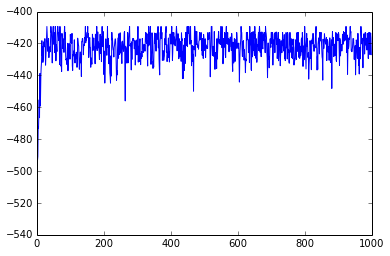

In [103]:
plt.plot(range(len(liklihood_over_iterations)), liklihood_over_iterations)
plt.show()

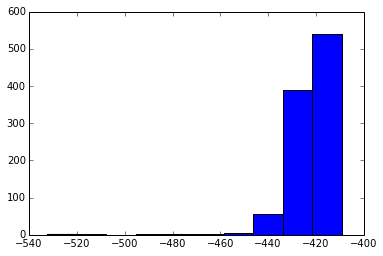

In [104]:
plt.hist(liklihood_over_iterations)
plt.show()

# Why does that look like a hard limit?

In [105]:
max(liklihood_over_iterations)

-409.33692017226076

In [106]:
len([liklihood for liklihood in liklihood_over_iterations if liklihood==max(liklihood_over_iterations)])

45

In [108]:
threshold = 0.5
indices_with_max_liklihood = [ind for ind,liklihood in enumerate(liklihood_over_iterations) if abs(liklihood-max(liklihood_over_iterations))<threshold]

In [109]:
indices_with_max_liklihood

[30,
 42,
 49,
 55,
 62,
 63,
 69,
 83,
 145,
 152,
 179,
 195,
 211,
 277,
 302,
 334,
 339,
 362,
 371,
 386,
 403,
 417,
 449,
 451,
 454,
 459,
 471,
 472,
 521,
 522,
 523,
 549,
 553,
 566,
 610,
 636,
 651,
 665,
 683,
 800,
 834,
 923,
 924,
 936,
 968]

In [110]:
len(indices_with_max_liklihood)

45

In [111]:
for ind,phi in enumerate(phi_over_iterations):
    print ind
    if ind in indices_with_max_liklihood:
        print phi

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
[[ 0.16160714  0.16160714  0.00089286  0.00089286  0.00089286  0.00089286
   0.16160714  0.00089286  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.16160714  0.10803571  0.05446429
   0.05446429  0.10803571  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.00089286]
 [ 0.1890625   0.1890625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0953125   0.0015625
   0.0953125   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0015

In [112]:
phi

array([[ 0.16160714,  0.16160714,  0.00089286,  0.00089286,  0.00089286,
         0.00089286,  0.16160714,  0.00089286,  0.00089286,  0.00089286,
         0.00089286,  0.00089286,  0.00089286,  0.00089286,  0.00089286,
         0.16160714,  0.10803571,  0.05446429,  0.05446429,  0.10803571,
         0.00089286,  0.00089286,  0.00089286,  0.00089286,  0.00089286,
         0.00089286,  0.00089286,  0.00089286,  0.00089286,  0.00089286,
         0.00089286,  0.00089286,  0.00089286,  0.00089286,  0.00089286,
         0.00089286,  0.00089286,  0.00089286,  0.00089286,  0.00089286],
       [ 0.1890625 ,  0.1890625 ,  0.0015625 ,  0.0015625 ,  0.0015625 ,
         0.0015625 ,  0.0015625 ,  0.0015625 ,  0.0015625 ,  0.0015625 ,
         0.0015625 ,  0.0015625 ,  0.0015625 ,  0.0015625 ,  0.0015625 ,
         0.0015625 ,  0.0953125 ,  0.0015625 ,  0.0953125 ,  0.0015625 ,
         0.0015625 ,  0.0015625 ,  0.0015625 ,  0.0015625 ,  0.0015625 ,
         0.0015625 ,  0.0015625 ,  0.0015625 ,  0.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
[[ 0.16160714  0.16160714  0.00089286  0.00089286  0.00089286  0.00089286
   0.16160714  0.00089286  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.16160714  0.10803571  0.05446429
   0.05446429  0.10803571  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.00089286  0.00089286  0.00089286
   0.00089286  0.00089286  0.00089286  0.00089286]
 [ 0.1890625   0.1890625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0953125   0.0015625
   0.0953125   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625   0.0015625
   0.0015625   0.0015625   0.0015625   0.0015625   0.0015

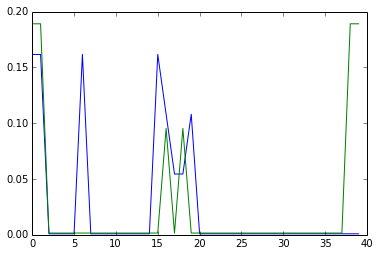

In [114]:
for ind,phi in enumerate(phi_over_iterations):
    print ind
    if ind in indices_with_max_liklihood:
        print phi
        x = phi[0,:]
        plt.plot(range(len(x)), x)
        y = phi[1,:]
        plt.plot(range(len(y)), y,color='g')
        plt.show()
        break

## After 5 iterations

In [88]:
phi

array([[ 0.175     ,  0.09166667,  0.00833333,  0.00833333,  0.00833333,
         0.00833333,  0.00833333,  0.00833333,  0.00833333,  0.00833333,
         0.00833333,  0.00833333,  0.00833333,  0.00833333,  0.00833333,
         0.00833333,  0.00833333,  0.00833333,  0.09166667,  0.00833333,
         0.00833333,  0.00833333,  0.00833333,  0.00833333,  0.00833333,
         0.00833333,  0.00833333,  0.00833333,  0.00833333,  0.00833333,
         0.00833333,  0.00833333,  0.00833333,  0.00833333,  0.00833333,
         0.00833333,  0.00833333,  0.00833333,  0.175     ,  0.175     ],
       [ 0.12916667,  0.17083333,  0.00416667,  0.00416667,  0.00416667,
         0.00416667,  0.12916667,  0.00416667,  0.00416667,  0.00416667,
         0.00416667,  0.00416667,  0.00416667,  0.00416667,  0.00416667,
         0.12916667,  0.12916667,  0.04583333,  0.04583333,  0.0875    ,
         0.00416667,  0.00416667,  0.00416667,  0.00416667,  0.00416667,
         0.00416667,  0.00416667,  0.00416667,  0.

In [28]:
%matplotlib inline 

In [29]:
import matplotlib.pyplot as plt

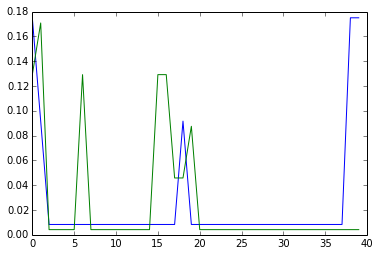

In [93]:
# [[1, 2, 7, 16,         19, 20],
#  [1, 2, 7, 16, 17,         20],
#  [1, 2, 7, 16, 17, 18],
#  [1, 2,                19,     39, 40],
#  [1, 2,        17,             39, 40]]


x = phi[0,:]
plt.plot(range(len(x)), x)
y = phi[1,:]
plt.plot(range(len(y)), y,color='g')
plt.show()

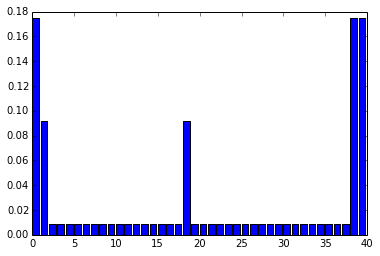

In [112]:
# [[1, 2, 7, 16,         19, 20],
#  [1, 2, 7, 16, 17,         20],
#  [1, 2, 7, 16, 17, 18],
#  [1, 2,                19,     39, 40],
#  [1, 2,        17,             39, 40]]

x = phi[0,:]
#print len(x)
plt.bar(range(len(x)),x)
#y = phi[1,:]
#plt.hist(range(len(y)), y,color='g')
plt.show()

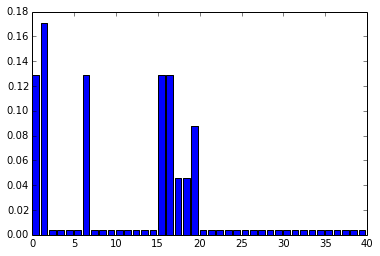

In [113]:
# [[1, 2, 7, 16,         19, 20],
#  [1, 2, 7, 16, 17,         20],
#  [1, 2, 7, 16, 17, 18],
#  [1, 2,                19,     39, 40],
#  [1, 2,        17,             39, 40]]

x = phi[1,:]
#print len(x)
plt.bar(range(len(x)),x)
#y = phi[1,:]
#plt.hist(range(len(y)), y,color='g')
plt.show()

## After 30 iterations

In [116]:
phi

array([[ 0.18888889,  0.11481481,  0.0037037 ,  0.0037037 ,  0.0037037 ,
         0.0037037 ,  0.11481481,  0.0037037 ,  0.0037037 ,  0.0037037 ,
         0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,
         0.11481481,  0.11481481,  0.04074074,  0.04074074,  0.07777778,
         0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,
         0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,
         0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,
         0.0037037 ,  0.0037037 ,  0.0037037 ,  0.0037037 ,  0.07777778],
       [ 0.01111111,  0.23333333,  0.01111111,  0.01111111,  0.01111111,
         0.01111111,  0.01111111,  0.01111111,  0.01111111,  0.01111111,
         0.01111111,  0.01111111,  0.01111111,  0.01111111,  0.01111111,
         0.01111111,  0.01111111,  0.01111111,  0.12222222,  0.01111111,
         0.01111111,  0.01111111,  0.01111111,  0.01111111,  0.01111111,
         0.01111111,  0.01111111,  0.01111111,  0.

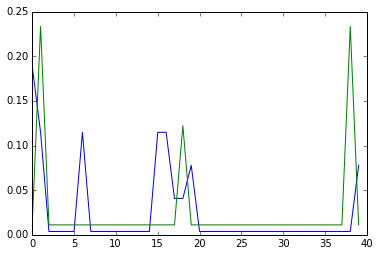

In [117]:
x = phi[0,:]
plt.plot(range(len(x)), x)
y = phi[1,:]
plt.plot(range(len(y)), y,color='g')
plt.show()

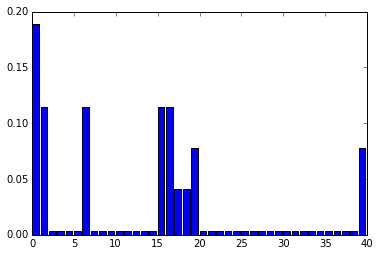

In [118]:
x = phi[0,:]
plt.bar(range(len(x)),x)
plt.show()

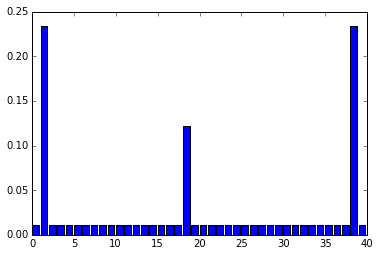

In [119]:
x = phi[1,:]
plt.bar(range(len(x)),x)
plt.show()

## After 100 iterations

In [11]:
phi

array([[ 0.01666667,  0.35      ,  0.01666667,  0.01666667,  0.01666667,
         0.01666667,  0.01666667,  0.01666667,  0.01666667,  0.01666667,
         0.01666667,  0.01666667,  0.01666667,  0.01666667,  0.01666667,
         0.01666667,  0.01666667,  0.01666667,  0.01666667,  0.01666667,
         0.01666667,  0.01666667,  0.01666667,  0.01666667,  0.01666667,
         0.01666667,  0.01666667,  0.01666667,  0.01666667,  0.01666667,
         0.01666667,  0.01666667,  0.01666667,  0.01666667,  0.01666667,
         0.01666667,  0.01666667,  0.01666667,  0.01666667,  0.01666667],
       [ 0.17      ,  0.10333333,  0.00333333,  0.00333333,  0.00333333,
         0.00333333,  0.10333333,  0.00333333,  0.00333333,  0.00333333,
         0.00333333,  0.00333333,  0.00333333,  0.00333333,  0.00333333,
         0.10333333,  0.10333333,  0.03666667,  0.07      ,  0.07      ,
         0.00333333,  0.00333333,  0.00333333,  0.00333333,  0.00333333,
         0.00333333,  0.00333333,  0.00333333,  0.

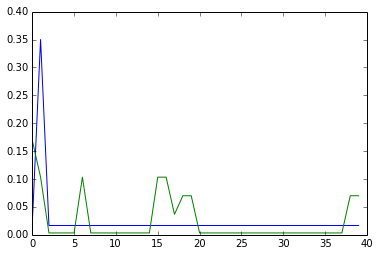

In [15]:
x = phi[0,:]
plt.plot(range(len(x)), x)
y = phi[1,:]
plt.plot(range(len(y)), y,color='g')
plt.show()

# Try it on 5 python solutions

In [1]:
#SUCK PYTHON DATA IN AND CREATE FEATURE VECTORS

import json
import numpy
from pprint import pprint

with open('/Users/elena/publicCodeRepos/overcode_data/iterPower-edx/output/solutions.json') as solutions_file:    
    solutions = json.load(solutions_file)

In [2]:
type(solutions)

list

In [3]:
len(solutions)

978

In [4]:
solutions[0]

{u'correct': True,
 u'count': 8,
 u'error_vector': [True, True, True, True, True, True, True, True],
 u'id': 1,
 u'lineIDs': {u'list': [1, 2, 3, 4, 5, 6, 7], u'type': u'set'},
 u'lines': [{u'indent': 0, u'line_obj_ID': 1, u'phraseID': 1},
  {u'indent': 4, u'line_obj_ID': 2, u'phraseID': 2},
  {u'indent': 4, u'line_obj_ID': 3, u'phraseID': 3},
  {u'indent': 4, u'line_obj_ID': 4, u'phraseID': 4},
  {u'indent': 8, u'line_obj_ID': 5, u'phraseID': 5},
  {u'indent': 8, u'line_obj_ID': 6, u'phraseID': 6},
  {u'indent': 4, u'line_obj_ID': 7, u'phraseID': 7}],
 u'members': [u'10',
  u'13277',
  u'17046',
  u'24153',
  u'25608',
  u'32167',
  u'5541',
  u'8371'],
 u'num_passed_tests': 8,
 u'number': u'10',
 u'phraseIDs': [1, 2, 3, 4, 5, 6, 7],
 u'stack_distances': {u'1': 1.0,
  u'10': 0.43956043956043955,
  u'100': 0.14285714285714285,
  u'101': 0.3968253968253968,
  u'102': 0.419047619047619,
  u'103': 0.4444444444444444,
  u'104': 0.5625,
  u'105': 0.5892857142857143,
  u'106': 0.25,
  u'107':

In [5]:
solution_correctness = [sol['correct'] for sol in solutions]

In [6]:
solution_counts = [sol['count'] for sol in solutions]

In [7]:
solution_counts

[8,
 1,
 148,
 1515,
 2,
 1,
 2,
 3,
 357,
 29,
 1,
 29,
 43,
 1,
 1,
 1,
 4,
 9,
 13,
 4,
 9,
 1,
 1,
 15,
 2,
 88,
 2,
 4,
 1,
 2,
 2,
 1,
 1,
 3,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 15,
 1,
 23,
 9,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 7,
 2,
 1,
 4,
 1,
 2,
 32,
 1,
 22,
 1,
 6,
 2,
 9,
 1,
 1,
 2,
 1,
 1,
 7,
 11,
 1,
 5,
 1,
 1,
 4,
 2,
 1,
 5,
 2,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 24,
 19,
 1,
 17,
 1,
 1,
 1,
 1,
 17,
 20,
 1,
 1,
 14,
 2,
 1,
 1,
 2,
 22,
 11,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 6,
 16,
 3,
 14,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 6,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 4,
 2,
 4,
 1,
 26,
 2,
 2,
 1,
 3,
 2,
 1,
 10,
 5,
 1,
 1,
 9,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 11,
 1,
 2,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 4,
 1,
 1,
 2,
 1,
 1,
 2,
 4,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 

In [23]:
counts,bins = numpy.histogram(solution_counts,bins=range(1,2000))

In [24]:
counts

array([798,  87,  22, ...,   0,   0,   0])

In [25]:
bins

array([   1,    2,    3, ..., 1997, 1998, 1999])

In [26]:
#for index in numpy.nonzero(counts):
for bin_index,count in enumerate(counts):
    if count > 0:
        print bin_index+1,count

1 798
2 87
3 22
4 14
5 10
6 7
7 5
8 2
9 6
10 1
11 3
13 1
14 2
15 2
16 1
17 2
19 1
20 1
22 2
23 1
24 1
26 1
29 2
32 1
43 1
88 1
148 1
357 1
1515 1


In [32]:
biggest_sol = [sol for sol in solutions if sol['count']==1515][0]

In [33]:
biggest_sol.keys()

[u'count',
 u'lineIDs',
 u'error_vector',
 u'num_passed_tests',
 u'lines',
 u'number',
 u'testcases',
 u'id',
 u'phraseIDs',
 u'total_num_tests',
 u'variableIDs',
 u'members',
 u'test_input_outputs',
 u'correct',
 u'stack_distances']

In [34]:
biggest_sol['correct']

True

In [35]:
biggest_sol['count']

1515

In [36]:
biggest_sol['variableIDs']

[2, 3, 7]

In [37]:
biggest_sol['phraseIDs']

[2, 5, 7, 16, 17, 20]

In [39]:
biggest_sol['lineIDs']['list']

[1, 2, 7, 16, 19, 20]

In [40]:
second_biggest_sol = [sol for sol in solutions if sol['count']==357][0]

In [41]:
second_biggest_sol

{u'correct': True,
 u'count': 357,
 u'error_vector': [True, True, True, True, True, True, True, True],
 u'id': 9,
 u'lineIDs': {u'list': [1, 2, 7, 16, 17, 20], u'type': u'set'},
 u'lines': [{u'indent': 0, u'line_obj_ID': 1, u'phraseID': 16},
  {u'indent': 4, u'line_obj_ID': 2, u'phraseID': 2},
  {u'indent': 4, u'line_obj_ID': 16, u'phraseID': 17},
  {u'indent': 8, u'line_obj_ID': 17, u'phraseID': 18},
  {u'indent': 8, u'line_obj_ID': 20, u'phraseID': 20},
  {u'indent': 4, u'line_obj_ID': 7, u'phraseID': 7}],
 u'members': [u'10076',
  u'10117',
  u'10131',
  u'10206',
  u'10226',
  u'10324',
  u'1037',
  u'10500',
  u'10678',
  u'1068',
  u'10858',
  u'10958',
  u'1100',
  u'11098',
  u'11107',
  u'11273',
  u'1128',
  u'11378',
  u'11397',
  u'11432',
  u'11541',
  u'11580',
  u'11593',
  u'11594',
  u'11603',
  u'11614',
  u'11621',
  u'11905',
  u'12107',
  u'12117',
  u'12165',
  u'12345',
  u'12529',
  u'12660',
  u'12925',
  u'12971',
  u'13037',
  u'13091',
  u'1330',
  u'1352',


In [46]:
third_biggest_sol = [sol for sol in solutions if sol['count']==148][0]

In [66]:
fourth_biggest_sol = [sol for sol in solutions if sol['count']==88][0]

In [67]:
fifth_biggest_sol = [sol for sol in solutions if sol['count']==43][0]

In [94]:
biggest_sol_6 = [sol for sol in solutions if sol['count']==32][0]
biggest_sol_7 = [sol for sol in solutions if sol['count']==29][0]
biggest_sol_8 = [sol for sol in solutions if sol['count']==26][0]
biggest_sol_9 = [sol for sol in solutions if sol['count']==23][0]
biggest_sol_10 = [sol for sol in solutions if sol['count']==22][0]

In [68]:
biggest_sols_list = [biggest_sol,second_biggest_sol,third_biggest_sol,fourth_biggest_sol,fifth_biggest_sol]

In [100]:
second_biggest_sols_list = [biggest_sol_6,biggest_sol_7,biggest_sol_8,biggest_sol_9,biggest_sol_10]

In [101]:
[sol['lineIDs']['list'] for sol in second_biggest_sols_list]

[[1, 7, 16, 19, 20, 61],
 [1, 2, 7, 16, 20, 25],
 [8, 1, 305, 29, 49],
 [40, 1, 2, 106, 17],
 [1, 2, 7, 16, 146, 23]]

In [102]:
biggest_sol['members'][0]

u'10009'

In [103]:
[sol['lineIDs']['list'] for sol in biggest_sols_list]

[[1, 2, 7, 16, 19, 20],
 [1, 2, 7, 16, 17, 20],
 [1, 2, 7, 16, 17, 18],
 [40, 1, 2, 19, 39],
 [40, 1, 2, 17, 39]]

In [104]:
[sol['members'][0] for sol in biggest_sols_list]

[u'10009', u'10076', u'10005', u'10412', u'10132']

In [105]:
[sol['members'][0] for sol in second_biggest_sols_list]

[u'11052', u'10083', u'13022', u'10683', u'11079']

In [75]:
#What do those solutions look like?

#There's only three actual design decisions in the top 5:
# *= vs. = *
# -= vs. = -
# while vs. for
#Can we infer these equivalent design decisions based on the same behavior?
#Should I automatically collapse *= vs. = *? What would happen if I did?
#How will topic modeling handling these?

# Top 5 within top 10:

# [1, 2, 7, 16, 19, 20],
#  [1, 2, 7, 16, 17, 20],
#  [1, 2, 7, 16, 17, 18],
#  [40, 1, 2, 19, 39],
#  [40, 1, 2, 17, 39]

#10009.py
result = 1
while exp > 0:
    result *= base
    exp -= 1
return result

#10076.py
result = 1
while exp > 0:
    result = result * base
    exp -= 1
return result

#10005.py
result = 1
while exp > 0:
   result = result * base
   exp = exp - 1
return result

#10412.py
res = 1
for i in range(exp):
    res *= base
return res

#10132.py
t=1
for i in range(exp):
    t=t*base
return t

##Second five in the top ten:

#  [1,    7,     16, 19, 20,          61]
#  [1, 2, 7,     16,     20, 25]
#  [1,       8,                29, 49,      305]
#  [1, 2,          17,          40, 106]
#  [1, 2, 7,    16,        23,           146]

#There are __ actual design decisions in the second half of the top 10:
# initialize as = 1 or =1.0
# wrap expression in (  ) or not
# include unneccessary argument in range or not (0)

#11052.py
res = 1.0
while exp > 0:
    res *= base
    exp -= 1
return res

#10083.py
result=1
while (exp>0):
    result=base*result
    exp-=1
return result

#13022.py
if(exp == 0):
    return 1
else:
    return base * iterPower(base,exp-1)

#10683.py
result = 1
for i in range(0,exp):
    result = result*base
return result

#11079.py
result = 1
while exp > 0:
    exp -= 1
    result *= base
return result

NameError: name 'exp' is not defined

In [49]:
with open('/Users/elena/publicCodeRepos/overcode_data/iterPower-edx/output/lines.json') as lines_file:    
    lines = json.load(lines_file)

In [54]:
lines[0]

{u'expanded_representation': u"def iterPower(___,___): ||| [{'iterPower(-4.52, 4)': ['myNaN'], 'iterPower(5.07, 0)': ['myNaN'], 'iterPower(-6.11, 1)': ['myNaN'], 'iterPower(-8.51, 8)': ['myNaN'], 'iterPower(7.79, 0)': ['myNaN'], 'iterPower(-4.54, 9)': ['myNaN'], 'iterPower(-6.45, 0)': ['myNaN'], 'iterPower(5.13, 10)': ['myNaN']}, {'iterPower(-4.52, 4)': ['myNaN'], 'iterPower(5.07, 0)': ['myNaN'], 'iterPower(-6.11, 1)': ['myNaN'], 'iterPower(-8.51, 8)': ['myNaN'], 'iterPower(7.79, 0)': ['myNaN'], 'iterPower(-4.54, 9)': ['myNaN'], 'iterPower(-6.45, 0)': ['myNaN'], 'iterPower(5.13, 10)': ['myNaN']}]",
 u'id': 1,
 u'line_values': [{u'iterPower(-4.52, 4)': [u'myNaN'],
   u'iterPower(-4.54, 9)': [u'myNaN'],
   u'iterPower(-6.11, 1)': [u'myNaN'],
   u'iterPower(-6.45, 0)': [u'myNaN'],
   u'iterPower(-8.51, 8)': [u'myNaN'],
   u'iterPower(5.07, 0)': [u'myNaN'],
   u'iterPower(5.13, 10)': [u'myNaN'],
   u'iterPower(7.79, 0)': [u'myNaN']},
  {u'iterPower(-4.52, 4)': [u'myNaN'],
   u'iterPower(-4

In [55]:
lines[1]

{u'expanded_representation': u"___=1 ||| [{'iterPower(-4.52, 4)': [], 'iterPower(5.07, 0)': [], 'iterPower(-6.11, 1)': [], 'iterPower(-8.51, 8)': [], 'iterPower(7.79, 0)': [], 'iterPower(-4.54, 9)': [], 'iterPower(-6.45, 0)': [], 'iterPower(5.13, 10)': []}]",
 u'id': 2,
 u'line_values': [{u'iterPower(-4.52, 4)': [],
   u'iterPower(-4.54, 9)': [],
   u'iterPower(-6.11, 1)': [],
   u'iterPower(-6.45, 0)': [],
   u'iterPower(-8.51, 8)': [],
   u'iterPower(5.07, 0)': [],
   u'iterPower(5.13, 10)': [],
   u'iterPower(7.79, 0)': []}],
 u'template': u'___=1'}

In [59]:
lines[6]

{u'expanded_representation': u"return ___ ||| [{'iterPower(-4.52, 4)': [1, -4.52, 20.430399999999995, -92.34540799999996], 'iterPower(5.07, 0)': [], 'iterPower(-6.11, 1)': [1], 'iterPower(-8.51, 8)': [1, -8.51, 72.42009999999999, -616.295051, 5244.670884009999, -44632.149222925094, 379819.58988709253, -3232264.709939157], 'iterPower(7.79, 0)': [], 'iterPower(-4.54, 9)': [1, -4.54, 20.6116, -93.576664, 424.83805456, -1928.7647677024, 8756.592045368896, -39754.92788597479, 180487.37260232554], 'iterPower(-6.45, 0)': [], 'iterPower(5.13, 10)': [1, 5.13, 26.3169, 135.005697, 692.57922561, 3552.9314273792997, 18226.53822245581, 93502.1410811983, 479665.98374654725, 2460686.4966197875]}]",
 u'id': 7,
 u'line_values': [{u'iterPower(-4.52, 4)': [1,
    -4.52,
    20.430399999999995,
    -92.34540799999996],
   u'iterPower(-4.54, 9)': [1,
    -4.54,
    20.6116,
    -93.576664,
    424.83805456,
    -1928.7647677024,
    8756.592045368896,
    -39754.92788597479,
    180487.37260232554],
   u'i

In [60]:
lines[15]

{u'expanded_representation': u"while ___>0: ||| [{'iterPower(-4.52, 4)': ['myNaN', 4], 'iterPower(5.07, 0)': ['myNaN', 0], 'iterPower(-6.11, 1)': ['myNaN', 1], 'iterPower(-8.51, 8)': ['myNaN', 8], 'iterPower(7.79, 0)': ['myNaN', 0], 'iterPower(-4.54, 9)': ['myNaN', 9], 'iterPower(-6.45, 0)': ['myNaN', 0], 'iterPower(5.13, 10)': ['myNaN', 10]}]",
 u'id': 16,
 u'line_values': [{u'iterPower(-4.52, 4)': [u'myNaN', 4],
   u'iterPower(-4.54, 9)': [u'myNaN', 9],
   u'iterPower(-6.11, 1)': [u'myNaN', 1],
   u'iterPower(-6.45, 0)': [u'myNaN', 0],
   u'iterPower(-8.51, 8)': [u'myNaN', 8],
   u'iterPower(5.07, 0)': [u'myNaN', 0],
   u'iterPower(5.13, 10)': [u'myNaN', 10],
   u'iterPower(7.79, 0)': [u'myNaN', 0]}],
 u'template': u'while ___>0:'}

In [61]:
lines[16]

{u'expanded_representation': u"___=___*___ ||| [{'iterPower(-4.52, 4)': ['myNaN'], 'iterPower(5.07, 0)': ['myNaN'], 'iterPower(-6.11, 1)': ['myNaN'], 'iterPower(-8.51, 8)': ['myNaN'], 'iterPower(7.79, 0)': ['myNaN'], 'iterPower(-4.54, 9)': ['myNaN'], 'iterPower(-6.45, 0)': ['myNaN'], 'iterPower(5.13, 10)': ['myNaN']}, {'iterPower(-4.52, 4)': ['myNaN'], 'iterPower(5.07, 0)': ['myNaN'], 'iterPower(-6.11, 1)': ['myNaN'], 'iterPower(-8.51, 8)': ['myNaN'], 'iterPower(7.79, 0)': ['myNaN'], 'iterPower(-4.54, 9)': ['myNaN'], 'iterPower(-6.45, 0)': ['myNaN'], 'iterPower(5.13, 10)': ['myNaN']}, {'iterPower(-4.52, 4)': [-4.52], 'iterPower(5.07, 0)': [5.07], 'iterPower(-6.11, 1)': [-6.11], 'iterPower(-8.51, 8)': [-8.51], 'iterPower(7.79, 0)': [7.79], 'iterPower(-4.54, 9)': [-4.54], 'iterPower(-6.45, 0)': [-6.45], 'iterPower(5.13, 10)': [5.13]}]",
 u'id': 17,
 u'line_values': [{u'iterPower(-4.52, 4)': [u'myNaN'],
   u'iterPower(-4.54, 9)': [u'myNaN'],
   u'iterPower(-6.11, 1)': [u'myNaN'],
   u'ite

In [62]:
lines[17]

{u'expanded_representation': u"___=___-1 ||| [{'iterPower(-4.52, 4)': [4, 3, 2, 1, 0], 'iterPower(5.07, 0)': [0], 'iterPower(-6.11, 1)': [1, 0], 'iterPower(-8.51, 8)': [8, 7, 6, 5, 4, 3, 2, 1, 0], 'iterPower(7.79, 0)': [0], 'iterPower(-4.54, 9)': [9, 8, 7, 6, 5, 4, 3, 2, 1, 0], 'iterPower(-6.45, 0)': [0], 'iterPower(5.13, 10)': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]}, {'iterPower(-4.52, 4)': [4, 3, 2, 1, 0], 'iterPower(5.07, 0)': [0], 'iterPower(-6.11, 1)': [1, 0], 'iterPower(-8.51, 8)': [8, 7, 6, 5, 4, 3, 2, 1, 0], 'iterPower(7.79, 0)': [0], 'iterPower(-4.54, 9)': [9, 8, 7, 6, 5, 4, 3, 2, 1, 0], 'iterPower(-6.45, 0)': [0], 'iterPower(5.13, 10)': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]}]",
 u'id': 18,
 u'line_values': [{u'iterPower(-4.52, 4)': [4, 3, 2, 1, 0],
   u'iterPower(-4.54, 9)': [9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
   u'iterPower(-6.11, 1)': [1, 0],
   u'iterPower(-6.45, 0)': [0],
   u'iterPower(-8.51, 8)': [8, 7, 6, 5, 4, 3, 2, 1, 0],
   u'iterPower(5.07, 0)': [0],
   u'iterPower(5.13, 10)'

In [63]:
lines[18]

{u'expanded_representation': u"___*=___ ||| [{'iterPower(-4.52, 4)': ['myNaN'], 'iterPower(5.07, 0)': ['myNaN'], 'iterPower(-6.11, 1)': ['myNaN'], 'iterPower(-8.51, 8)': ['myNaN'], 'iterPower(7.79, 0)': ['myNaN'], 'iterPower(-4.54, 9)': ['myNaN'], 'iterPower(-6.45, 0)': ['myNaN'], 'iterPower(5.13, 10)': ['myNaN']}, {'iterPower(-4.52, 4)': [-4.52], 'iterPower(5.07, 0)': [5.07], 'iterPower(-6.11, 1)': [-6.11], 'iterPower(-8.51, 8)': [-8.51], 'iterPower(7.79, 0)': [7.79], 'iterPower(-4.54, 9)': [-4.54], 'iterPower(-6.45, 0)': [-6.45], 'iterPower(5.13, 10)': [5.13]}]",
 u'id': 19,
 u'line_values': [{u'iterPower(-4.52, 4)': [u'myNaN'],
   u'iterPower(-4.54, 9)': [u'myNaN'],
   u'iterPower(-6.11, 1)': [u'myNaN'],
   u'iterPower(-6.45, 0)': [u'myNaN'],
   u'iterPower(-8.51, 8)': [u'myNaN'],
   u'iterPower(5.07, 0)': [u'myNaN'],
   u'iterPower(5.13, 10)': [u'myNaN'],
   u'iterPower(7.79, 0)': [u'myNaN']},
  {u'iterPower(-4.52, 4)': [-4.52],
   u'iterPower(-4.54, 9)': [-4.54],
   u'iterPower(-6

In [64]:
lines[19]

{u'expanded_representation': u"___-=1 ||| [{'iterPower(-4.52, 4)': [4, 3, 2, 1, 0], 'iterPower(5.07, 0)': [0], 'iterPower(-6.11, 1)': [1, 0], 'iterPower(-8.51, 8)': [8, 7, 6, 5, 4, 3, 2, 1, 0], 'iterPower(7.79, 0)': [0], 'iterPower(-4.54, 9)': [9, 8, 7, 6, 5, 4, 3, 2, 1, 0], 'iterPower(-6.45, 0)': [0], 'iterPower(5.13, 10)': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]}]",
 u'id': 20,
 u'line_values': [{u'iterPower(-4.52, 4)': [4, 3, 2, 1, 0],
   u'iterPower(-4.54, 9)': [9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
   u'iterPower(-6.11, 1)': [1, 0],
   u'iterPower(-6.45, 0)': [0],
   u'iterPower(-8.51, 8)': [8, 7, 6, 5, 4, 3, 2, 1, 0],
   u'iterPower(5.07, 0)': [0],
   u'iterPower(5.13, 10)': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
   u'iterPower(7.79, 0)': [0]}],
 u'template': u'___-=1'}

In [10]:
import matplotlib.pyplot as plt
plt.hist(solution_counts,bins=range(1,2000))
#(array([0, 2, 1]), array([0, 1, 2, 3]), <a list of 3 Patch objects>)
plt.show()

## Log-log plot

In [ ]:
bins = range(1,2000)
plt.xticks(bins, ["2^%s" % i for i in bins])
plt.hist(numpy.log2(solution_counts), log=True, bins=bins)
plt.show()

KeyboardInterrupt: 

In [ ]:
numpy.log2(solution_counts)